In [2]:
!pip3 install torchvision

     |████████████████████████████████| 387 kB 2.2 MB/s eta 0:00:01


In [3]:
import tvm
from tvm import relay

import numpy as np

from tvm.contrib.download import download_testdata

# PyTorch imports
import torch
import torchvision

Load a pretrained PyTorch model



In [4]:
model_name = "resnet18"
model = getattr(torchvision.models, model_name)(pretrained=True)
model = model.eval()

# We grab the TorchScripted model via tracing
input_shape = [1, 3, 224, 224]
input_data = torch.randn(input_shape)
scripted_model = torch.jit.trace(model, input_data).eval()

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /Users/axelstjerngren/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth
100.0%


Load a test image

File /Users/axelstjerngren/.tvm_test_data/data/cat.png exists, skip.


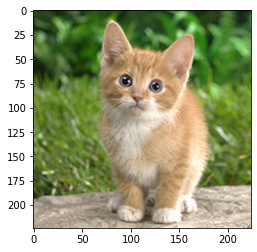

In [31]:
from PIL import Image
from IPython.display import display # to display images
from matplotlib import pyplot as plt

img_url = "https://github.com/dmlc/mxnet.js/blob/master/data/cat.png?raw=true"
img_path = download_testdata(img_url, "cat.png", module="data")
img = Image.open(img_path).resize((224, 224))

# Preprocess the image and convert to tensor
from torchvision import transforms

my_preprocess = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

plt.figure()
plt.imshow(img)



img = my_preprocess(img)
img = np.expand_dims(img, 0)




Import the graph to Relay

Convert PyTorch graph to Relay graph. The input name can be arbitrary.



In [17]:
input_name = "input0"
shape_list = [(input_name, img.shape)]
mod, params = relay.frontend.from_pytorch(scripted_model, shape_list)


Relay Build

Compile the graph to llvm target with given input specification.

In [18]:
target = "llvm"
target_host = "llvm"
ctx = tvm.cpu(0)
with tvm.transform.PassContext(opt_level=3):
    lib = relay.build(mod, target=target, target_host=target_host, params=params)
    

Cannot find config for target=llvm -keys=cpu, workload=('dense_nopack.x86', ('TENSOR', (1, 512), 'float32'), ('TENSOR', (1000, 512), 'float32'), None, 'float32'). A fallback configuration is used, which may bring great performance regression.


In [19]:
from tvm.contrib import graph_runtime

dtype = "float32"
m = graph_runtime.GraphModule(lib["default"](ctx))
# Set inputs
m.set_input(input_name, tvm.nd.array(img.astype(dtype)))
# Execute
m.run()
# Get outputs
tvm_output = m.get_output(0)

In [20]:
synset_url = "".join(
    [
        "https://raw.githubusercontent.com/Cadene/",
        "pretrained-models.pytorch/master/data/",
        "imagenet_synsets.txt",
    ]
)
synset_name = "imagenet_synsets.txt"
synset_path = download_testdata(synset_url, synset_name, module="data")
with open(synset_path) as f:
    synsets = f.readlines()

synsets = [x.strip() for x in synsets]
splits = [line.split(" ") for line in synsets]
key_to_classname = {spl[0]: " ".join(spl[1:]) for spl in splits}

class_url = "".join(
    [
        "https://raw.githubusercontent.com/Cadene/",
        "pretrained-models.pytorch/master/data/",
        "imagenet_classes.txt",
    ]
)
class_name = "imagenet_classes.txt"
class_path = download_testdata(class_url, class_name, module="data")
with open(class_path) as f:
    class_id_to_key = f.readlines()

class_id_to_key = [x.strip() for x in class_id_to_key]

# Get top-1 result for TVM
top1_tvm = np.argmax(tvm_output.asnumpy()[0])
tvm_class_key = class_id_to_key[top1_tvm]

# Convert input to PyTorch variable and get PyTorch result for comparison
with torch.no_grad():
    torch_img = torch.from_numpy(img)
    output = model(torch_img)

    # Get top-1 result for PyTorch
    top1_torch = np.argmax(output.numpy())
    torch_class_key = class_id_to_key[top1_torch]

print("Relay top-1 id: {}, class name: {}".format(top1_tvm, key_to_classname[tvm_class_key]))
print("Torch top-1 id: {}, class name: {}".format(top1_torch, key_to_classname[torch_class_key]))


...100%, 0.05 MB, 179 KB/s, 0 seconds passed
...100%, 0.02 MB, 59 KB/s, 0 seconds passed
Relay top-1 id: 281, class name: tabby, tabby cat
Torch top-1 id: 281, class name: tabby, tabby cat


In [44]:
plt.figure()
plt.imshow(torch_img[0
                    ,1])




IndexError: index 1 is out of bounds for dimension 0 with size 1

<Figure size 432x288 with 0 Axes>